In [1]:
import torch
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
# from PID_INC import PID_INC


class pid_loss(nn.Module):
    def __init__(self, min, max, dt) -> None:
        super(pid_loss, self).__init__()
        self.min = min
        self.max = max
        self.dt = dt 
        self.ei = 0
        self.ed = 0
        self.pre_err = 0

    def forward(self, input, measure, target):
        kp, ki, kd = input
        error = target - measure
        u = kp*error + ki*self.ei + kd*self.ed
        self.ei = self.ei + error*self.dt
        self.ed = (error - self.pre_err)/self.dt
        self.pre_err = error
        return u

class BP_PID(nn.Module):
    def __init__(self, inputchannels, hiddenchannel, outputchannels) -> None:
        super(BP_PID, self).__init__()

        self.inputlayer = nn.Sequential(nn.Linear(inputchannels, hiddenchannel),
                                        nn.ReLU())
        self.hiddenlayers = nn.Sequential(nn.Linear(hiddenchannel, hiddenchannel*2),
                                         nn.ReLU(),
                                         nn.Linear(hiddenchannel*2, hiddenchannel),
                                         nn.ReLU())
        self.outputlayer = nn.Sequential(nn.Linear(hiddenchannel, outputchannels),
                                         nn.ReLU())
    def forward(self, x):
        x = self.inputlayer(x)
        x = self.hiddenlayers(x)
        x = self.outputlayer(x)
        return x

In [2]:
model = BP_PID(3, 10, 3)
opt = torch.optim.SGD(model.parameters(), lr=1e-4, weight_decay=0.00)
loss_func = pid_loss(-100, 100, 0.1)
y = 5
target = 20
data_in = torch.tensor([target, 5, target-y], dtype=torch.float32) #输入为目标值，实际值，误差
y_list = [5]
T_list = [0]
k_list = []

for epoch in range(100):
    opt.zero_grad()
    out = model(data_in)
    loss = loss_func(out, torch.tensor(y, dtype=torch.float32), torch.tensor(target, dtype=torch.float32))
    loss.requires_grad_(True)
    loss.backward()
    opt.step()
    data_in = torch.tensor([target, 5+loss.item(), target-(5+loss.item())], dtype=torch.float32)
    y = y+loss.item()
    print(loss.item())
    T_list.append((epoch+1)*0.1)
    y_list.append(y)
    k_list.append(out.detach().numpy())
    

6.435193061828613
5.953512191772461
2.167118787765503
0.35853222012519836
0.14105170965194702
0.07601393759250641
0.04053737595677376
0.020006991922855377
0.008087068796157837
0.0011914968490600586
-0.0027639344334602356
-0.004998743534088135
-0.006225548684597015
-0.006864003837108612
-0.0071607232093811035
-0.007258616387844086
-0.007245548069477081
-0.00716930627822876
-0.007060188800096512
-0.006935935467481613
-0.006804890930652618
-0.006674900650978088
-0.006546922028064728
-0.006424076855182648
-0.006307691335678101
-0.006197676062583923
-0.00609453022480011
-0.005997626110911369
-0.0059065986424684525
-0.0058223288506269455
-0.005745114758610725
-0.005673309788107872
-0.005607111379504204
-0.005547812208533287
-0.0054931920021772385
-0.005444610491394997
-0.005401025526225567
-0.005363872274756432
-0.0053314147517085075
-0.005303374491631985
-0.005281812511384487
-0.005264787934720516
-0.0036564143374562263
-0.0022231321781873703
-0.0013520362554118037
-0.0008218630682677031
-0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


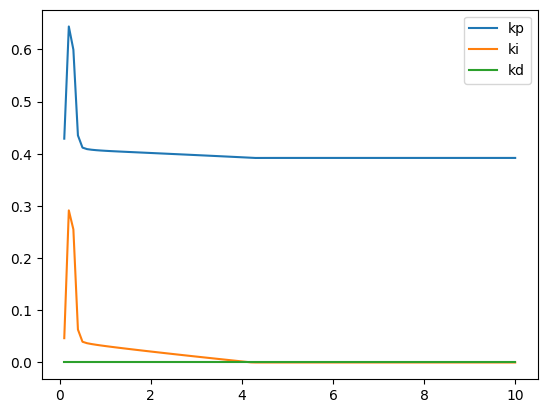

In [6]:
a = np.array(k_list)
plt.plot(T_list[1:], a[:,], label=['kp', 'ki', 'kd'])
plt.legend()
plt.savefig('result/K.eps', dpi=600)
plt.show()

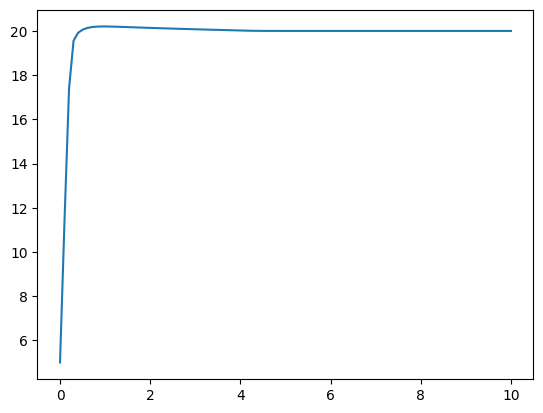

In [4]:
plt.plot(T_list, y_list)

In [5]:
import pandas as pd
y_bp_df = pd.DataFrame({'T': T_list, 'BP_PID_OUT': y_list})
k_bp_df = pd.DataFrame({'T': T_list[1:], 'KP': a[:,0], 'KI': a[:,1], 'KD': a[:,2]})
y_bp_df.to_csv('result//BP_PID_OUT.csv', index=None)
k_bp_df.to_csv('result/K_BP.csv', index=None)